# 필요 라이브러리 설치

In [1]:
# !pip install gensim --upgrade
# !pip install -U keras-tuner
# !pip install pymysql
# !pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 1.1 MB/s eta 0:00:00a 0:00:01


# 라이브러리 불러오기

In [2]:
import IPython
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pandas as pd
import numpy as np
import pymysql

# MySQL 연동

In [2]:
# conn = pymysql.connect(
#                         user    = 'stocks',
#                         passwd  = 'Stocks!',
#                         host    = "AWS 주소",
#                         port    = 3306,
#                         db      = 'Data',
#                         charset = 'utf8'
#         )

# 데이터 불러오기

In [3]:
# sql = 'SELECT stock_id, text, date, token, label FROM Token'
# news = pd.read_sql(sql, conn)
news = pd.read_csv('./Token.csv', index_col=0)

# 데이터 전처리

## Token을 str -> list 형태로 변환

In [4]:
import re

def str_to_list(d):
  text = re.sub(r'[\[\'\]]', '', d)
  return text.split(", ")

news["token"] = news.token.apply(str_to_list)

## 불용어 처리

In [5]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword and not i.isdigit()]
tqdm.pandas()
news["token"] = news.token.progress_apply(stopword)
news

100%|██████████| 1788/1788 [00:00<00:00, 7728.68it/s]


,stock_id,date_time,title,content,token
0,12450,2023-07-03 15:15:00,"전경련·보훈부·한화, 참전용사 300명에 맞춤 신발 헌정",전국경제인연합회와 국가보훈부 한화에어로스페이스는 이달 말 국군과 유엔군 참전용사의 ...,"[전국, 경제인, 연합회, 국가, 보훈, 부, 한화, 어로, 스페이스, 이달, 말,..."
1,12450,2023-07-03 14:33:00,"현대로템, 폴란드 석박사 50명 육성한다… 학비·연구비 60억원 지원",현대로템은 지난달 일 방위사업청과 한국과학기술원 한화에어로스페이스 한국항공우주산업과...,"[현대, 로템, 지난달, 일, 방위, 사업, 청과, 한국, 과학, 기술원, 한화, ..."
2,12450,2023-07-03 11:38:00,전쟁중 뒤틀려진 발… 300명에 ‘영웅의 신발’ 헌정,전쟁이 진행 중이던 년 월 설악산 근무 중 다리에 총을 맞는 등 최일선에서 격전을 ...,"[전쟁, 진행, 중이, 덜, ㄴ, 년, 월, 설악산, 근무, 중, 다리, 총, 을,..."
3,12450,2023-07-03 11:30:00,"현대로템, 폴란드 방산 분야 인재 양성 지원",폴란드 석박사 명 년까지 서 교육한폴 인적 교류 확대해 신뢰 구축방산 협력 기여앞줄...,"[폴란드, 석, 박사, 명, 년, 까지, 스, 어, 교육, ㄴ, 폴, 인적, 교류,..."
4,12450,2023-07-03 11:18:00,전경련 “나라 헌신한 300명에 맞춤형 신발”,월말 수호자 발걸음 프로젝트보훈부와 복지증진 업무협약김병준왼쪽 전경련 회장직무대행과...,"[월말, 수호자, 발걸음, 프로젝트, 보훈, 부와, 복지, 증진, 업무, 협약, 김..."
...,...,...,...,...,...
1783,12450,2021-06-29 04:31:00,"한화-삼성 빅딜, 누가 승자였을까",내준 사업 승승장구에삼성은 배 안 아플까삼성그룹 또한 한화와 빅딜로 플러스 효과를...,"[내주, ㄴ, 사업, 승승장구, 삼성, 배, 안, 아프, ㄹ까, 삼성, 그룹, 또한..."
1784,12450,2021-06-28 17:39:00,비행기 뜨지도 않았는데 항공부품株는 '이륙'…두달새 주가 20% 올랐다,항공기 엔진 부품 수혜 전망두달새 주가 넘게 올라 올 하반기 실적 호조 지속 전망에...,"[항공기, 엔진, 부품, 수혜, 전망, 두, 닿, ㄹ새, 주가, 넘, 게, 오르, ..."
1785,12450,2021-06-28 14:36:00,"한화, 100% 해외 의존 인공위성 심장 '추력기' 국산화 한다",한화가 해외에서 수입하던 인공위성 핵심 부품의 국산화에 나선다 우주 사업을 미래 ...,"[한화, 해외, 에서, 수입, 더, ㄴ, 인공위성, 핵심, 부품, 국산화, 나서, ..."
1786,12450,2021-06-28 10:25:00,"㈜한화, 인공위성 심장 ‘추력기’ 국산화 개발 나선다",저장성 이원추진제 추력기이미지주한화한화그룹이 미래 먹거리로 점찍은 인공위성 사업 확...,"[저장성, 이원, 추진제, 추력, 기, 이미지, 주한, 화한, 화, 그룹, 미래, ..."


# 모델링

## 데이터 셋 나누기

In [6]:
test = news.loc[news["date"] >= '2022-07-01 00:00:00']
train = news.loc[news["date"] < '2022-07-01 00:00:00']

X_train = train['token']
y_train = train['label']
X_test = test['token']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

KeyError: 'date'

## Tokenizer

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [8]:
threshold = 4
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq += value

  if value < threshold:
    rare_cnt +=1
    rare_freq += value

print("전체 단어 수", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수: {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율: {}".format((rare_cnt / words_cnt) * 100))
print("희귀 단어 등장 빈도 비율: {}".format((rare_freq / words_freq) * 100))

전체 단어 수 62463
빈도가 3 이하인 희귀 단어 수: 18802
희귀 단어 비율: 30.101019803723805
희귀 단어 등장 빈도 비율: 0.07036167954849475


In [9]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

43663


In [10]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_trian = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

94918
94918


/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [13]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_trian)) / len(X_train))

리뷰 최대 길이: 5759
리뷰 평균 길이: 489.9088054952696


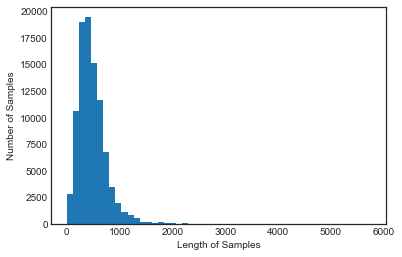

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
max_len = 800

In [16]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [17]:
model = Sequential()
model.add(Embedding(vocab_size, 800))
model.add(Bidirectional(LSTM(256, return_sequences = True, dropout = 0.5)))
model.add(Bidirectional(LSTM(224)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer = keras.optimizers.Nadam(learning_rate = 0.001),
              loss = keras.losses.BinaryCrossentropy(), 
              metrics = ['accuracy'])
model.summary()

2022-08-05 14:26:10.211308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 800)         34930400  
                                                                 
 bidirectional (Bidirectiona  (None, None, 512)        2164736   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 448)              1320704   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 449       
                                                                 
Total params: 38,416,289
Trainable params: 38,416,289
Non-trainable params: 0
_________________________________________________________________


In [18]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('BiLSTM_best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [19]:
history = model.fit(X_train, y_train, epochs=5, validation_split = 0.2, callbacks=[es, mc], batch_size = 128)

Epoch 1/5
 88/594 [===>..........................] - ETA: 6:49:22 - loss: 0.7050 - accuracy: 0.5225

In [ ]:
loaded_model = load_model('BiLSTM_best_model.h5')
loaded_model.evaluate(X_test, y_test)